# **GSAlign**
An efficient sequence alignment tool for intra-species genomes using BWT.  
**Features**  
- Handles large genome sequence alignment efficiently
- Identifies sequence variants from the alignment result
- faster than most existing state-of-the-art methods, but also identifies sequence variants with high accuracy
- ultra-fast alignment as well as high accuracy and sensitivity for detecting sequence variations
- GSAlign can produce the alignments of normal pairs simultaneously with multi-threads.


Thesholds in this implementation have been chosen to be able to better visualise the small input we have provided.<br>
For exact paper implementation with thresholds, actual gene alignment visit github: https://github.com/WizardOfMoz/ABIN-Project

In [2]:
import pandas as pd 
import numpy as np  
import random
from Bio import pairwise2
from Bio.Seq import Seq 

**Algothim Overview**

1. LMEM identification
    - a local maximal exact match (LMEM) is a common substring between two genomes that begins at a specific position of query sequence and finds LMEMs with variable relengths and then converts those LMEMs into simple pairs.

    - A simple pair represents a pair of identical sequence fragments, one from the reference and one from the query sequence. 
<br>
2. Similar region identification
    - GSAlign clusters those simple pairs into disjoint groups
    - Each group represents a similar region. 
    - GSAlign then finds all local gaps in each similar region. 
    - A local gap (defined as a normal pair) is the gap between two adjacent simple pairs. 
3. Alignment Process
    - GSAlign closes gaps to build a complete local alignment for each similar region and identifies all sequence variations during the process





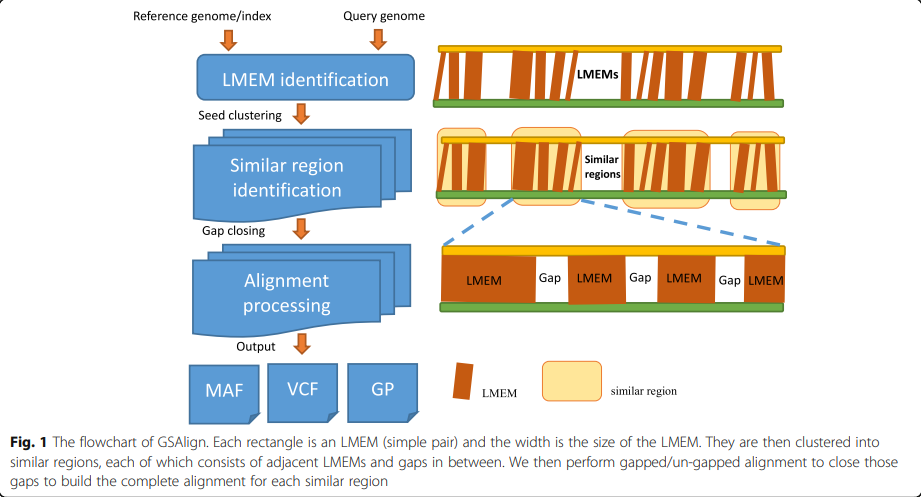

BWT-based read mappers are more memory efficient than hash table based mappers. In this study, we used BWT to perform seed exploration 
for genome sequence alignment, to find the exact matches .  <br> 
<br> 

In [3]:
# for efficient exact matching, we use the Burrows-Wheeler transform for efficient exact matching

def bwt(p):
    """Burrows-Wheeler transform of a string"""
    if len(p)==0:
        return None
    s='$'+p
    rotations = list(enumerate([s[i:] + s[:i] for i in range(len(s))]))
    rotations.sort(key=lambda x: x[-1])
    df = pd.DataFrame([[rot[0],rot[1][0],rot[1][-1]] for rot in rotations])
    df.columns = ['index','L','R']

    
    letters = sorted(list(df['R'].unique()))
    rank = pd.DataFrame()
    for let in letters:
        rank[let] = (df['R']==let).cumsum() - (df['R']==let)
    
    rank.loc[len(s)]=df['R'].value_counts().sort_index()

    rng = pd.DataFrame([],index=letters)
    d = df['L'].value_counts().sort_index()
    rng['start']=d.cumsum() - d
    rng['end']=d.cumsum()
    return df ,rank,rng

In [4]:
# Uses BWT to get the exact matching regions in the 2 sequences, hence we find the lmems or the exactly similar regions in the 2 sequences

def get_lmem(q,df,rank,rng):
    """Burrows-Wheeler search of a string"""
    n =len(q)
    st,end = rng.loc[q[-1]]
    j2 = n-1
    lmem_list=[]
    # Threshold for the minimum length of lmem
    l_=2
    for j in range(n-2,-1,-1):
        q_ = q[j]
        st_ = rank.loc[st,q_]
        end_ = rank.loc[end,q_]
        
        if(st_==end_):
            j1 = j+1 
            l = j2-j1
            if(l>=l_-1):
                i1=df.iloc[st:end]['index'].values[0]-1
                i2 = i1 + l
                lmem_list.append((i1,i2+1,j1,j2+1,i1-j1))
            j2 = j
            st = rng.loc[q_,'start']
            end = rng.loc[q_,'end']

        elif j == 0:
            st = rng.loc[q_,'start'] + st_
            end = rng.loc[q_,'start'] + end_     
            j1 = j
            l = j2-j1
            if(l>=l_-1):
                i1=df.iloc[st:end]['index'].values[0]-1
                i2 = i1 + l
                lmem_list.append((i1,i2+1,j1,j2+1,i1-j1))

        else:
            st = rng.loc[q_,'start'] + st_
            end = rng.loc[q_,'start'] + end_
        
    return lmem_list  

**Making sets of alignments that are colinear**

If two simple pairs have similar PosDiff, they are co-linear. We sort all simple pairs according to their PosDiff to group all co-linear simple pairs

In [5]:
# if two simple pair (locally aligned substring of seq1 and seq2) has similar position difference (that is difference in their startig position in sequence 2) 
# then they are collinear and in this function we are finding sets of such pairs. 

# If the starting position of the adjacent simple pairs, in the second sequence is less than the threshhold value, then they are added to the set.

def get_colinear_sets(lmem_list):
    """Get colinear sets from lmem_list"""
    lmem_list.sort(key=lambda x: x[-1])
    thresh = 10
    colinear_sets = []
    l= [lmem_list[0]]
    for i in range(1,len(lmem_list)):
        if abs(lmem_list[i][-1]-lmem_list[i-1][-1])<=thresh:
            l.append(lmem_list[i])
        else:
            if(len(l)>1):
                colinear_sets.append(l)
            l = [lmem_list[i]]
    if len(l)>1:
        colinear_sets.append(l)
    return colinear_sets

**Removing Overlaps**

Given two adjacent simple pairs in the same cluster we find the overlaps. In such cases, the overlapping fragment is chopped off from the smaller
simple pair.


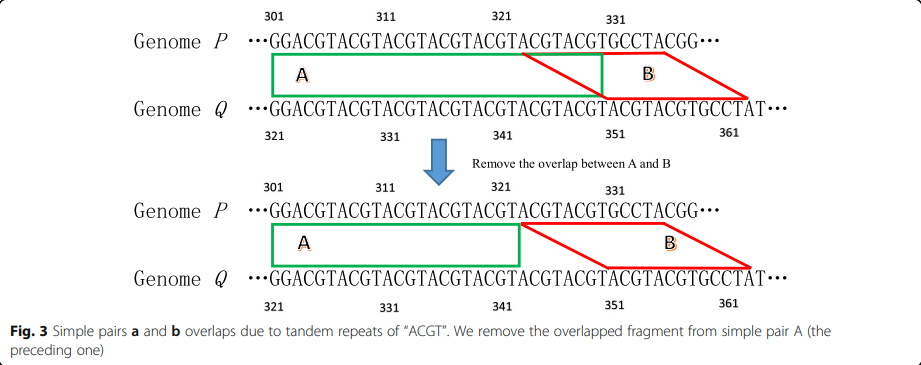

In [6]:
# Lets consider two simple pairs in the same cluster, sa =(ia,1; ia,2; ja,1; ja,2) and sb = (ib,1; ib,2; jb,1; jb,2)
# if ia,1 ≤ ib,1 ≤ ia,2 OR ja,1 ≤ jb,1 ≤ ja,2 then these pairs are overlapping. In such cases, we have to modify the pairs to remove the overlap

# In such cases, the overlapping fragment is chopped off from the smaller simple pair and is modifies accordingly

def remove_overlap(col_set):
    for i in range(len(col_set)-1):
        lmem1 = col_set[i]
        lmem2 = col_set[i+1]
        l1 = lmem1[1]-lmem1[0]
        l2 = lmem2[1]-lmem2[0]
        if lmem1[1]>lmem2[0]:
            if l1>l2:
                col_set[i+1] = [lmem1[1],lmem2[1],lmem2[2],lmem2[2]+lmem2[1]-lmem1[1],lmem2[2]-lmem1[1]]
            else:
                col_set[i] = [lmem1[0],lmem2[0],lmem1[2],lmem1[2]+lmem2[0]-lmem1[0],lmem1[4]]
    return col_set


**Removing outliers**

Since simple pairs are re-sorted by their positions at sequence Q,
some of them may be not co-linear with their adjacent
simple pairs and they are considered as outliers.
 We remove those outliers from the simple pair group.

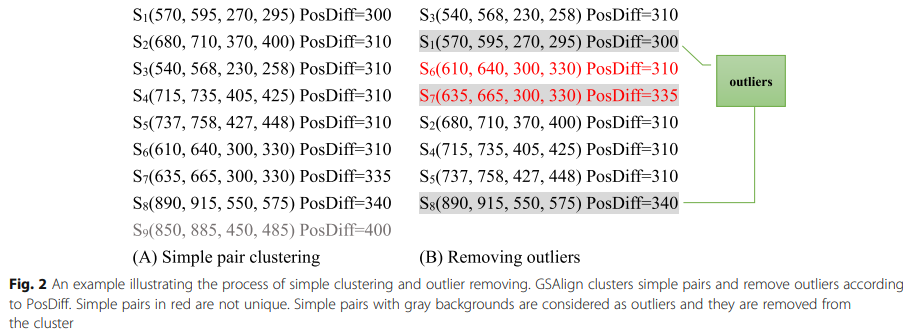

In [7]:
# Once the simple pairs are arranged according to the stariting position in the second sequence, we may have few pairs that are not
# co-linear with their adjacent simple pairs and they are considered as outliers, which need to be removed from the set. 

# For this, we define a threshold value and if the position difference between the adjacent simple pairs is less than that then they are 
# non-outliers. Set of such non-outliers is returned by this function.  

def non_outlier(col_set):
    col_set.sort(key=lambda x: x[2])
    thresh = 5
    n=len(col_set)
    dp = np.ones(n)
    for i in range(1,n):
        for j in range(i-1,-1,-1):
            if abs(col_set[i][-1]-col_set[j][-1])<=thresh:
                dp[i] = max(dp[i],dp[j]+1)
    i = dp.argmax()
    non_outlier_set = [col_set[i]]
    for j in range(i-1,-1,-1):
        if (abs(col_set[i][-1]-col_set[j][-1])<=thresh) and (dp[j]==dp[i]-1):
            non_outlier_set.append(col_set[j])
            i=j
    non_outlier_set.reverse()
    return non_outlier_set


In [8]:
# here we are returning the processed colinear set, that is after removing the outliers and handling the overlaps. 

def preprocess_colinear_sets(colinear_sets): 
    """Preprocess colinear sets"""
    for i in range(len(colinear_sets)):
        col_set = colinear_sets[i]
        col_set.sort(key=lambda x: x[2])
        col_set = non_outlier(col_set) # Remove outliers
        col_set = remove_overlap(col_set) # Remove overlaps
        colinear_sets[i] = col_set
    return colinear_sets

**Considering Sequences**

In [9]:
# Incase of presence of FASTA file, we use the code in the github repo containing the FASTA files.
# Considering given strings as input for easier visualization
p='ATGCTCTTCCGAGCTGTGCTGCTCTGCGCTGCCCTGGCGCTCAGCCATGCAGGTGAGTGAGTGGCTTCGCGCCCCGAAGCACCCCTGGAGGGACTCCTCTGGCTCAGACCCCTTTCTAGGAGTATGGGATGGGCTGTG'
q='AGAGTCACCACTACGTCACGTGGAGTCCGCTTTACAGACTTAAAAGCAAGGTTCTCCCCATTAGCAGCCAGTTGTCAAACTGCGAGCTAAGAGCTTCAGGAGTCAGTCAGGACTCTGCTCACGAAGGAACTCAGCATG'


In [10]:
df,rank,rng = bwt(p)
print("BWT indexes")
df

BWT indexes


,index,L,R
0,0,$,G
1,77,A,G
2,81,A,C
3,108,A,G
4,93,A,G
...,...,...,...
134,15,T,C
135,7,T,C
136,66,T,C
137,114,T,T


In [11]:
lmem_set = get_lmem(q,df,rank,rng)
pd.DataFrame(lmem_set,columns=['i1','i2','j1','j2','offset'])

,i1,i2,j1,j2,offset
0,45,49,134,138,-89
1,102,107,129,134,-27
2,75,78,126,129,-51
3,74,79,121,126,-47
4,101,106,116,121,-15
5,21,25,112,116,-91
6,117,121,108,112,9
7,103,105,106,108,-3
8,103,107,102,106,1
9,117,122,97,102,20


In [12]:
# to get the colinear set of the simple pairs
colinear_sets = get_colinear_sets(lmem_set)
colinear_sets

[[(21, 25, 112, 116, -91), (45, 49, 134, 138, -89)],
 [(75, 78, 126, 129, -51),
  (28, 31, 79, 82, -51),
  (74, 79, 121, 126, -47),
  (6, 8, 51, 53, -45)],
 [(5, 8, 38, 41, -33),
  (63, 68, 92, 97, -29),
  (102, 107, 129, 134, -27),
  (41, 46, 64, 69, -23),
  (7, 10, 25, 28, -18),
  (101, 106, 116, 121, -15),
  (44, 48, 57, 61, -13),
  (103, 105, 106, 108, -3),
  (76, 78, 77, 79, -1),
  (103, 107, 102, 106, 1),
  (117, 121, 108, 112, 9),
  (10, 13, 1, 4, 9),
  (105, 108, 89, 92, 16),
  (117, 122, 97, 102, 20),
  (115, 118, 86, 89, 29),
  (103, 106, 74, 77, 29),
  (76, 81, 43, 48, 33),
  (76, 78, 41, 43, 35),
  (63, 67, 28, 32, 35),
  (44, 47, 7, 10, 37),
  (93, 97, 53, 57, 40)],
 [(120, 123, 69, 72, 51),
  (116, 119, 61, 64, 55),
  (74, 76, 18, 20, 56),
  (74, 76, 13, 15, 61),
  (136, 138, 72, 74, 64),
  (85, 90, 20, 25, 65),
  (117, 120, 48, 51, 69),
  (104, 108, 34, 38, 70)],
 [(116, 118, 32, 34, 84), (103, 106, 15, 18, 88)],
 [(103, 106, 4, 7, 99), (115, 118, 10, 13, 105)]]

In [13]:
# to process the colinear set (removing ouliers and handling overlaps) obtained in previous step
colinear_sets = preprocess_colinear_sets(colinear_sets)
colinear_sets

[[(21, 25, 112, 116, -91), (45, 49, 134, 138, -89)],
 [(28, 31, 79, 82, -51), (74, 79, 121, 126, -47), [79, 78, 126, 125, 47]],
 [(44, 47, 7, 10, 37),
  (63, 67, 28, 32, 35),
  [76, 76, 41, 41, 35],
  (76, 81, 43, 48, 33),
  (103, 106, 74, 77, 29),
  (115, 118, 86, 89, 29)],
 [(74, 76, 13, 15, 61),
  (85, 90, 20, 25, 65),
  (104, 108, 34, 38, 70),
  (117, 120, 48, 51, 69),
  (136, 138, 72, 74, 64)],
 [(103, 106, 15, 18, 88), (116, 118, 32, 34, 84)],
 [(103, 106, 4, 7, 99)]]

**Finding the normal pairs**

In the collinear regions or similar pairs we find the intermediate gaps to align.

In [14]:
#touple as in (i1,i2,j1,j2), removing gaps that are >15 for consideration in alignment
normal_set=[]
for similar_set in colinear_sets:
    sets=[]
    for i in range(len(similar_set)-1):
        exact_region1=similar_set[i]
        exact_region2=similar_set[i+1]
        if exact_region2[0]-exact_region1[1]>15 or exact_region1[3]-exact_region2[2]>15:
            continue
        gap_region=(exact_region1[1],exact_region2[0],exact_region1[3],exact_region2[2])
        sets.append(gap_region)
    normal_set.append(sets)

In [15]:
normal_set

[[],
 [(79, 79, 126, 126)],
 [(67, 76, 32, 41), (76, 76, 41, 43), (106, 115, 77, 86)],
 [(76, 85, 15, 20), (90, 104, 25, 34), (108, 117, 38, 48)],
 [(106, 116, 18, 32)],
 []]

In [16]:
similar_regions={}
normal_regions={}

In [17]:
for sim_r in colinear_sets:
    for touple in sim_r:
        similar_regions[touple[0]]=touple

In [18]:
for gap_r in normal_set:
    for touple in gap_r:
        normal_regions[touple[0]]=touple

In [19]:
final_p=""
final_q=""
alignment=""

**Alignment**

There are 3 kids of gapped regions:
1. Type 1: 
    - If the fragment pair has
equal size and the number of mismatches in a linear
scan is less than a threshold
2. Type 2:  
    - I if one of the fragment is a
null string and the other contains at least one
nucleobase
3. The remaining normal pairs are Type 3  

*The paper utilized KSW2 algorithm for this purpose, we use Bio Seq library . It takes care of all the 3 cases we are looking into.* 

In [20]:
# Creating the final alignment, identifying the LMEMs , exact regions and gap regions and aligning them accordingly
position = 0
while position<len(p):
    if position in similar_regions:
        touple=similar_regions[position]
        final_p+=p[touple[0]:touple[1]]
        final_q+=q[touple[2]:touple[3]]
        alignment+="|"*(touple[1]-touple[0])
        position=touple[1]
    elif position in normal_regions:
        touple=normal_regions[position]
        tempp=p[touple[0]:touple[1]]
        tempq=q[touple[2]:touple[3]]
        alignments = pairwise2.align.globalms(tempp, tempq,2, -.5,-.5,-0.5)
        onealignment=alignments[0]  # taking only 1 max score alignment since otherwise there could be many possiblities
        alignment_p=onealignment[0]
        alignment_q=onealignment[1]
        all=""
        for i in range(len(alignment_p)): 
            if alignment_p[i]==alignment_q[i]:
                all+="|" 
            else:
                all+=" "
        alignment+=all
        final_p+=alignment_p
        final_q+=alignment_q
        position=touple[1]
    else:
        final_p+=p[position]
        final_q+=q[position]
        position+=1
        alignment+=" "

In [22]:
print("Alignment")
print()
print(final_p)
print(alignment)
print(final_q)

Alignment

ATGCTCTTCCGAGCTGTGCTGCTCTGCGCTGCCCTGGCGCTCAGCCATGCAGGTGAGTGAGTGGCTTCGC-GCCCCGAAGCACCCCTGGAGGGACTCCTCTGGCT-CAGACCCCTTT----CTAGGAGTATGGGATGGGCTGTG
                     ||||   |||             |||                ||||  | |  |  |||||    |||||    ||| ||   | ||||   |||     | |||                ||
AGAGTCACCACTACGTCACGTCTCTTCCCTGTTACAGACTTAAACCAAAGGTTCTCCCCATTAGCTTTACAG-ACTTAAGCAGCGATGGAG----TCCGCT--TTACAGA---CTTAAAAGCAAGGACGAAGGAACTCAGCATG


*Since the paper utilizes parallel programming and has access to multiple cores they were able to utilize the ability to have multiple alignments in the similar regions, however we have used one of the most optimal alignment*

As more genome sequences become available, the demand for genome comparison is increasing. Therefore, an efficient and robust algorithm is most desirable. We believe GSAlign can be a useful tool. It shows the abilities of ultra-fast alignment as well as high accuracy and sensitivity for detecting sequence variations
